# H2O Avocado

#### Goal :

- Create a ML model using Auto-sklearn for the Avocado dataset
- Get RMSE over the predictions of these model

#### Imports

In [1]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.automl import H2OAutoML
from time import process_time

In [2]:
#h2o.cluster().shutdown(prompt=True) 
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp19c83mar
  JVM stdout: /tmp/tmp19c83mar/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp19c83mar/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,09 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.4
H2O_cluster_version_age:,1 month
H2O_cluster_name:,H2O_from_python_unknownUser_1o1irg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,231.6 Mb
H2O_cluster_total_cores:,1
H2O_cluster_allowed_cores:,1
H2O_cluster_status:,"accepting new members, healthy"


Import of the Dataset already treated. There are only Integers and Floats because H2O don't handle String types

In [4]:
df = h2o.upload_file('../../Data/California_house/processed/train.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%


We use only the 500 hundred columns because the processing time would be to high for us
We then define the response expected as "SalePrice"
Then we define every other columns as the mean to make our prediction

In [5]:
df = df[range(1,500,1),:]
df["SalePrice"] = df["SalePrice"].asfactor()
response = "SalePrice"
predictors=[]
for col in df.columns:
    if col != "SalePrice":
        predictors.append(col)


We split our Dataset in training and testing sets (here "train" and "valid") with a 80% ratio
We can now define and train our model with a timer that will indicate us the time taken.

In [9]:
train = h2o.upload_file('../../Data/California_house/processed/train.csv')
valid = h2o.upload_file('../../Data/California_house/processed/test.csv')
print(train)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
905,20,-1,6173,5,6,1967,1967,75,599,0,277,876,902,0,0,902,0,0,1,0,3,1,6,0,1967,1,288,0,0,0,0,0,0,0,8,2007,125500,0,0,0,1,0,0,0,0,9,0,0,0,1,0,0,3,5,0,1,0,1,1,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0
961,20,50,7207,5,7,1958,2008,0,696,0,162,858,858,0,0,858,1,0,1,0,2,1,4,0,-1,0,0,117,0,0,0,0,0,0,2,2010,116500,0,0,0,1,0,0,0,0,8,0,0,0,1,0,0,2,4,1,1,1,1,1,0,1,4,0,0,1,0,0,1,0,0,4,3,3,2,0,0,0,0,0,0
240,50,52,8741,6,4,1945,1950,0,94,0,641,735,798,689,0,1487,0,0,1,1,3,1,7,1,1949,1,220,0,140,0,0,0,0,0,4,2010,113000,0,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,0,1,1,0,1,1,3,0,6,0,0,2,0,2,1,0,2,1,1,0,0,0,0,1,0,0,0
88,160,40,3951,6,5,2009,2009,76,0,0,612,612,612,612,0,1224,0,0,2,1,2,1,4,0,2009,2,528,0,234,0,0,0,0,0,6,2009,164500,3,0,2,0,0,0,2,0,5,0,0,3,0,0,0,0,0,2,0,0,0,0,0,3,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2
620,60,85,12244,8,5,2003,2003,226,871,0,611,1482,1482,780,0,2262,1,0,2,1,4,1,10,2,2003,3,749,168,0,0,0,0,0,0,8,2008,305000,0,0,0,0,0,0,0,0,16,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0
423,20,100,21750,5,5,1954,1954,0,0,0,988,988,988,0,0,988,0,0,1,0,2,1,4,0,1954,2,520,0,0,0,0,0,0,0,2,2008,113000,0,0,0,0,3,0,0,1,4,3,0,0,1,1,0,3,3,1,1,0,1,1,0,0,2,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0,0
1149,50,-1,5700,7,7,1926,1950,0,0,0,572,572,572,539,0,1111,0,0,1,0,2,1,5,1,1982,1,288,0,0,176,0,0,0,0,8,2008,116900,1,0,0,0,0,0,0,0,7,0,0,0,2,0,0,2,5,1,1,0,0,1,0,0,2,0,0,2,0,0,1,0,2,1,1,0,0,0,0,0,0,0,0
447,20,137,16492,6,6,1966,2002,0,247,713,557,1517,1888,0,0,1888,0,0,2,1,2,1,6,1,1966,2,578,0,0,0,0,0,0,0,6,2010,190000,0,0,0,1,0,0,2,0,11,7,0,0,1,0,0,4,4,1,0,0,1,1,0,0,1,4,0,0,0,0,0,4,2,0,2,0,0,0,0,0,0,0,0
1312,20,68,8814,7,5,2005,2007,80,925,0,349,1274,1274,0,0,1274,1,0,2,0,3,1,6,0,2005,2,508,264,98,0,0,0,0,0,1,2007,203000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
828,20,65,8529,7,5,2001,2001,0,20,0,1434,1454,1434,0,0,1434,0,0,2,0,3,1,6,1,2001,2,527,290,39,0,0,0,0,0,4,2009,189000,0,0,0,1,0,0,0,0,12,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [10]:
t1_start = process_time()
California_house_gbm = H2OGradientBoostingEstimator()

California_house_gbm.train(x = predictors,
               y = response,
               training_frame = train,
               validation_frame = valid)
t1_stop = process_time()

print("Elapsed time in seconds : ",t1_stop-t1_start)  

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Elapsed time in seconds :  0.1787705009999998


Display of the resulting model with all the importants features, such as :
-Variable Importances
-Scoring History
-RMSE

In [11]:
print(California_house_gbm)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1593679573774_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,13727.0,5.0,5.0,5.0,6.0,27.0,17.1




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 276406799.7696712
RMSE: 16625.48645212137
MAE: 10635.88677866181
RMSLE: 0.09133246789427218
Mean Residual Deviance: 276406799.7696712

ModelMetricsRegression: gbm
** Reported on validation data. **

MSE: 470964033.0787224
RMSE: 21701.705764264763
MAE: 15419.155863310361
RMSLE: 0.13613308124808027
Mean Residual Deviance: 470964033.0787224

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-07-02 08:50:53,0.089 sec,0.0,85004.534468,60468.949883,7.225771e+09,67028.708185,54395.551392,4.492848e+09
1,,2020-07-02 08:50:55,1.176 sec,1.0,77982.187449,55227.693954,6.081222e+09,61233.494300,49651.073276,3.749541e+09
2,,2020-07-02 08:50:55,1.354 sec,2.0,71740.303731,50542.679863,5.146671e+09,56051.903587,45406.627757,3.141816e+09
3,,2020-07-02 08:50:55,1.482 sec,3.0,66094.672852,46393.851211,4.368506e+09,51768.470871,41716.859371,2.679975e+09
4,,2020-07-02 08:50:55,1.602 sec,4.0,61174.408398,42596.322086,3.742308e+09,47773.514878,38263.645324,2.282309e+09
5,,2020-07-02 08:50:55,1.736 sec,5.0,56768.056900,39331.965651,3.222612e+09,44665.241332,35496.523375,1.994984e+09
6,,2020-07-02 08:50:55,1.838 sec,6.0,52611.382946,36279.966865,2.767958e+09,41921.893512,33006.358404,1.757445e+09
7,,2020-07-02 08:50:55,1.950 sec,7.0,48982.826825,33588.566223,2.399317e+09,39373.955462,30737.556322,1.550308e+09
8,,2020-07-02 08:50:55,2.057 sec,8.0,45662.335989,31083.991157,2.085049e+09,37009.037678,28556.129500,1.369669e+09
9,,2020-07-02 08:50:56,2.156 sec,9.0,42792.858628,28854.823140,1.831229e+09,34979.279985,26713.349614,1.223550e+09



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,OverallQual,2.135836e+13,1.000000,0.597087
1,GrLivArea,3.956822e+12,0.185259,0.110616
2,GarageCars,1.814295e+12,0.084945,0.050720
3,TotalBsmtSF,1.744683e+12,0.081686,0.048774
4,BsmtFinSF1,9.223265e+11,0.043183,0.025784
5,1stFlrSF,7.464958e+11,0.034951,0.020869
6,BedroomAbvGr,5.671900e+11,0.026556,0.015856
7,LotArea,3.855653e+11,0.018052,0.010779
8,YearRemodAdd,3.588912e+11,0.016803,0.010033
9,OpenPorchSF,3.000064e+11,0.014046,0.008387



See the whole table with table.as_data_frame()



We then see the results of these model on a new part of the dataset

In [12]:
df_imported = h2o.upload_file('../../Data/California_house/no_string_no_nan.csv')
df = df_imported[range(500,700,1),:]
df_newdata = df.drop("SalePrice",axis=1)

predictions = California_house_gbm.predict(df_newdata)

predictions = predictions["predict"].as_data_frame()
df_valid_newdata = df[:,"SalePrice"].as_data_frame()

from sklearn.metrics import mean_squared_error
from math import sqrt
print("rmse score:", sqrt(mean_squared_error(df_valid_newdata, predictions)))

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
rmse score: 20780.469501205484


We then see look at the residual plot

In [13]:
predictions = predictions["predict"]
y_test = df_valid_newdata["SalePrice"]

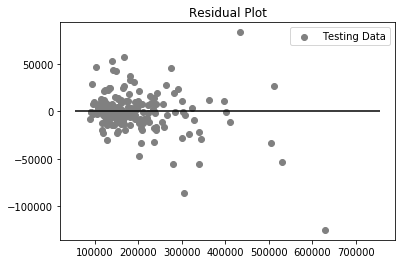

In [14]:
import matplotlib.pyplot as plt

#plot residuals
plt.scatter(predictions, predictions - y_test, c="grey", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()